# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

In [264]:
#Imports

# Imports
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from nbresult import ChallengeResult
import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from tensorflow.keras import optimizers
from tensorflow.image import resize
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Reshape, Conv2D

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  3315k      0  0:00:27  0:00:27 --:--:-- 2699k437k      0  0:00:26  0:00:23  0:00:03 3804k:27  0:00:27 --:--:-- 2599k
total 48
-rw-r--r--     1 Yohann  staff      0 Jun 29 09:12 README.md
-rw-r--r--@    1 Yohann  staff  21566 Jun 30 09:12 image_denoising.ipynb
drwx------  1087 Yohann  staff  34784 Jun  9 15:06 paintings
drwxr-xr-x     3 Yohann  staff     96 Jun 29 09:12 tests


In [151]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Joan_Miro_48.jpg',
 './paintings/Titian_232.jpg',
 './paintings/Amedeo_Modigliani_30.jpg',
 './paintings/Frida_Kahlo_21.jpg',
 './paintings/Marc_Chagall_59.jpg',
 './paintings/Salvador_Dali_116.jpg',
 './paintings/Vincent_van_Gogh_363.jpg',
 './paintings/Paul_Klee_47.jpg',
 './paintings/Kazimir_Malevich_106.jpg',
 './paintings/Leonardo_da_Vinci_7.jpg',
 './paintings/Francisco_Goya_199.jpg',
 './paintings/Vincent_van_Gogh_161.jpg',
 './paintings/Paul_Klee_90.jpg',
 './paintings/Paul_Cezanne_24.jpg',
 './paintings/Peter_Paul_Rubens_42.jpg',
 './paintings/Amedeo_Modigliani_184.jpg',
 './paintings/Titian_52.jpg',
 './paintings/Alfred_Sisley_165.jpg',
 './paintings/Paul_Gauguin_72.jpg',
 './paintings/Vincent_van_Gogh_767.jpg',
 './paintings/Raphael_106.jpg',
 './paintings/Pablo_Picasso_78.jpg',
 './paintings/Diego_Rivera_10.jpg',
 './paintings/Pieter_Bruegel_108.jpg',
 './paintings/Hieronymus_Bosch_25.jpg',
 './paintings/Joan_Miro_6.jpg',
 './paintings/Kazimir_Malevich_79.jpg'

In [208]:
len_df = len(dataset_paths)

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

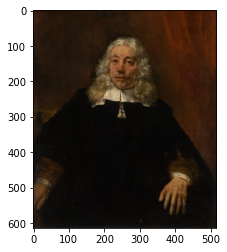

In [209]:
# We use the Image module from Pillow

im = Image.open(dataset_paths[53], )
plt.imshow(im)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [210]:
# YOUR CODE HERE

img_shape = im.size

print(im.mode)

RGB


In [211]:
#The image is colored (RGB) so it has 3 dimensions or channels
img_dim = 3
print(f'This image has a size of {img_shape} and {img_dim} dimensions.')

This image has a size of (517, 614) and 3 dimensions.


❓ **What was in the image above?**

In [212]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

is_colored_image = True
#is_colored_image = False

In [213]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [214]:
# YOUR CODE HERE
#my_array = numpy.empty(predict_length())
dataset_images = [np.asarray(Image.open(im)) for im in dataset_paths]

In [215]:
assert len(dataset_images) == len(dataset_paths)

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [216]:
# YOUR CODE HERE
len(set([image.shape[-1] for image in dataset_images]))

41

Basically we notice that not all images have 3 channels, meaning that 40 images are gray-scaled!

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [217]:
from tqdm import tqdm

dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:00<00:00, 2095.42it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [218]:
# Checking for width/heights
[image.shape for image in dataset_images]

[(358, 434, 3),
 (627, 604, 3),
 (484, 307, 3),
 (484, 352, 3),
 (461, 614, 3),
 (480, 626, 3),
 (614, 467, 3),
 (401, 479, 3),
 (600, 450, 3),
 (425, 618, 3),
 (639, 381, 3),
 (614, 463, 3),
 (362, 480, 3),
 (322, 384, 3),
 (474, 614, 3),
 (484, 368, 3),
 (556, 614, 3),
 (427, 614, 3),
 (489, 614, 3),
 (419, 614, 3),
 (614, 449, 3),
 (653, 261, 3),
 (480, 317, 3),
 (614, 469, 3),
 (234, 312, 3),
 (270, 181, 3),
 (360, 273, 3),
 (424, 300, 3),
 (660, 520, 3),
 (1229, 911, 3),
 (787, 510, 3),
 (299, 218, 3),
 (573, 561, 3),
 (971, 1214, 3),
 (526, 343, 3),
 (1229, 833, 3),
 (586, 789, 3),
 (360, 418, 3),
 (742, 597, 3),
 (614, 292, 3),
 (466, 394, 3),
 (482, 480, 3),
 (461, 334, 3),
 (614, 380, 3),
 (1229, 757, 3),
 (600, 398, 3),
 (670, 900, 3),
 (461, 326, 3),
 (253, 173, 3),
 (480, 346, 3),
 (614, 457, 3),
 (614, 422, 3),
 (615, 427, 3),
 (614, 517, 3),
 (361, 480, 3),
 (347, 540, 3),
 (614, 489, 3),
 (515, 768, 3),
 (365, 480, 3),
 (600, 535, 3),
 (1010, 1536, 3),
 (629, 630, 3),
 (

As we can notice width and heights are very different. Let's resize them!

In [219]:
#reshape
for i in range(len(dataset_images)):
    dataset_images[i] = resize(dataset_images[i], [120, 100])

In [220]:
# Checking for width/heights again
[image.shape for image in dataset_images]

[TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([120, 100, 3]),
 TensorShape([

In [221]:
#storing all images in a np array

dataset_resized = np.stack(dataset_images)


assert dataset_resized.shape == (len(dataset_paths), 120, 100, 3)

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [180]:
dataset_scaled = dataset_resized / 255

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [181]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

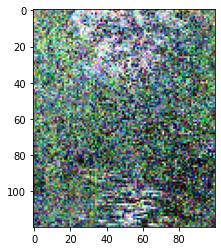

In [202]:
# YOUR CODE HERE
rdm_img = dataset_noisy[38]

# We reshape the array and display the noisy image
plt.imshow(rdm_img)

In [225]:
dataset_images[38]

<tf.Tensor: shape=(120, 100, 3), dtype=float32, numpy=
array([[[176.45337 , 199.01004 , 162.202   ],
        [148.25797 , 173.29471 , 130.57304 ],
        [137.44833 , 157.99146 , 132.25125 ],
        ...,
        [140.57213 , 141.9388  , 113.506805],
        [134.45943 , 164.5886  , 139.1977  ],
        [124.20023 , 137.19772 , 106.43745 ]],

       [[149.83588 , 173.59674 , 127.71587 ],
        [159.52386 , 175.62624 , 140.54149 ],
        [126.03999 , 148.165   , 116.914986],
        ...,
        [133.92    , 161.74074 , 114.145004],
        [143.12457 , 160.84164 , 134.89693 ],
        [123.31876 , 141.54376 ,  98.86877 ]],

       [[139.10396 , 148.70355 , 122.66917 ],
        [162.55917 , 177.37918 , 134.79626 ],
        [164.13644 , 196.43643 , 197.76665 ],
        ...,
        [ 89.2463  , 129.24629 ,  79.19839 ],
        [116.15462 , 133.87953 , 100.66168 ],
        [156.2417  , 171.2417  , 150.15837 ]],

       ...,

       [[ 98.86347 , 115.6557  , 122.254074],
        [ 90.

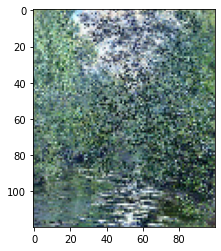

In [227]:
#And compare it with the original ... what a change!
plt.imshow(dataset_scaled[38])

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [230]:
#X -> noisy datasets, y-> original one 
X = dataset_noisy
Y = dataset_scaled

# Let's use sklearn's train test split to build our datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Let's make sure that shapes are .. in good shape ;-)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(868, 120, 100, 3) (868, 120, 100, 3)
(217, 120, 100, 3) (217, 120, 100, 3)


In [231]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [232]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [242]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [291]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY

encoder = Sequential()
    
encoder.add(Conv2D(8, (2,2), input_shape=(120, 100, 3), activation='relu'))
encoder.add(MaxPooling2D(2))
encoder.add(layers.Dropout(0.5))

encoder.add(Flatten())
encoder.add(Dense(latent_dimensions, activation='tanh'))

encoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 119, 99, 8)        104       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 59, 49, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 49, 8)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 23128)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 6000)              138774000 
Total params: 138,774,104
Trainable params: 138,774,104
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [292]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 6000)              138774104 
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 138,780,779
Trainable params: 138,780,779
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [295]:
# basic compilation with no hyperparameter tuning
autoencoder.compile(loss='binary_crossentropy',
              optimizer='adam',
                   metrics=['mae'])

autoencoder.fit(X_train, Y_train)
autoencoder.evaluate(X_test, Y_test)

7/7 [==============================] - 1s 92ms/step - loss: 0.6748 - mae: 0.2281


[0.6748453378677368, 0.22814196348190308]

In [262]:
score_baseline = 0.22814196348190308

In [296]:
X_train.shape

(868, 120, 100, 3)

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [299]:
# YOUR CODE HERE
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")

adam_opt = optimizers.Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.9)

autoencoder.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# We fit the model
history = autoencoder.fit(
    X_train, Y_train, 
    validation_split=0.2,   # 20% of the train set used for validation  
    epochs=1000, batch_size=8,   # Number of epochs is voluntarily large (due to the early stopping criterion)
    verbose=1,   # Print the loss and metric at each epoch
    callbacks=[es]   # Early stopping criterion
)

Epoch 1/1000



KeyboardInterrupt



❓ **Plot your training and validation loss at each epoch using the cell below**

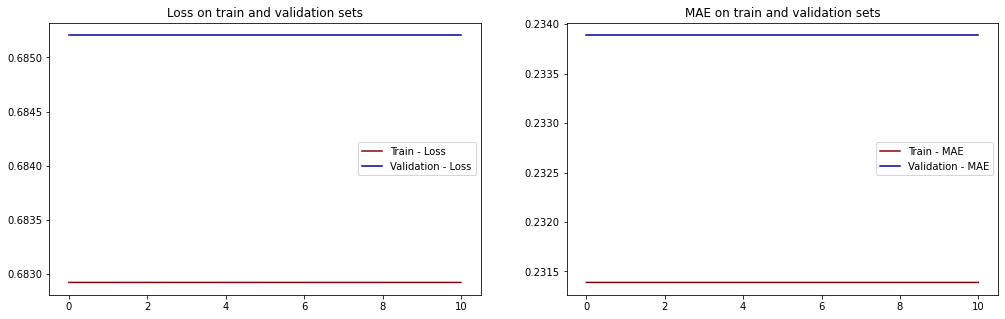

In [282]:
# Plot below your train/val loss history
# This function allows to plot the history of the training of the model
def plot_history(history):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 5))
    
    axes[0].plot(history.history['loss'], color = 'darkred', label = 'Train - Loss')
    axes[0].plot(history.history['val_loss'], color = 'darkblue', label = 'Validation - Loss')
    axes[0].legend()
    axes[0].set_title('Loss on train and validation sets')    
    
    axes[1].plot(history.history['mae'], color = 'darkred', label = 'Train - MAE')
    axes[1].plot(history.history['val_mae'], color = 'darkblue', label = 'Validation - MAE')
    axes[1].legend()
    axes[1].set_title('MAE on train and validation sets')

# We can run it for our model
plot_history(history)

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [585]:
# YOUR CODE HERE

In [591]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [588]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()